In [1]:
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.layers import Dense,LSTM,Dropout,Conv1D,MultiHeadAttention,LayerNormalization,Add
import tensorflow_io as tfio
from tensorflow import keras
import os
from pathlib import Path
from IPython import display
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
cd = Path.cwd()
data_path = os.path.join(cd,r'OneDrive\Desktop\Datasets\music-and-tabs')
music_path,tabs_path = [os.path.join(data_path,p) for p in os.listdir(data_path)]

music_paths = [os.path.join(music_path,p) for p in os.listdir(music_path)]
song_data = json.load(open(tabs_path,'r'))

audio_paths = []
capo_placements = []
tabs = []

for song in song_data:
    audio_path = os.path.join(music_path,song['audio_path'].split('/')[-1])
    capo_placement = song['capo_encoded'].index(1)
    tab = song['tab']
    
    if audio_path in music_paths:
        audio_paths.append(audio_path)
        capo_placements.append(capo_placement)
        tabs.append(tab)

### Functions to extract the sound, turns it into a spectrogram, and display it:

In [3]:
def extract_wav(path):
    
    sound = tf.io.read_file(path)
    sound = tf.audio.decode_wav(sound)[0]
    sound = tf.squeeze(sound)
    
    return sound[:,0]

def extract_sound(path):
    
    wav = tf.io.read_file(path)
    wav = tf.audio.decode_wav(wav)
    sound = tf.squeeze(wav[0]).numpy()
    rate = wav[1].numpy()
    audio = display.Audio(sound[:,0],rate=rate)
    
    return audio

frame_length = 2048
frame_step = 512
make_spectrogram = lambda wav,fl,fs: tf.abs(tf.signal.stft(wav,frame_length=fl,frame_step=fs))

sns.set_style('darkgrid')
def plot_wave_and_spectrogram(x,fl=frame_length,fs=frame_step):
    
    sound = extract_wav(path)
    spectrogram = make_spectrogram(sound,fl,fs)
    
    log_spec = tf.math.log(tf.transpose(spectrogram))

    x = np.linspace(0,np.size(spectrogram),log_spec.shape[1],dtype='int')
    y = range(log_spec.shape[0])
    
    plt.figure(figsize=(16,10))
    plt.subplot(2,1,1)
    plt.plot(sound)
    plt.subplot(2,1,2)
    plt.pcolormesh(x,y,log_spec,cmap='turbo')
    plt.show()

### A couple of examples of soundwaves and plotted spectrigrams:

C:\Users\tblon\OneDrive\Desktop\Datasets\music-and-tabs\audio\the_cranberries_zombie_intro_tab.wav
(653, 1025)


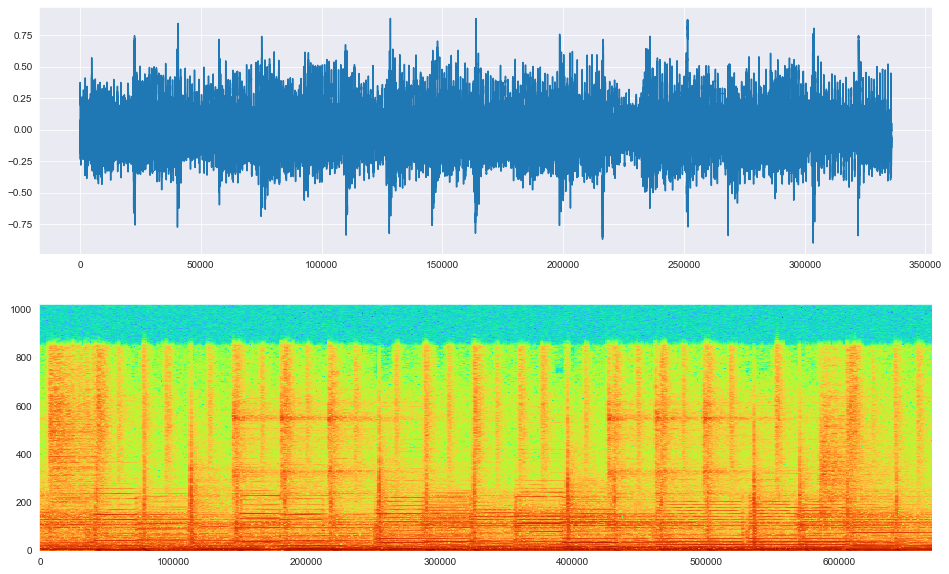


C:\Users\tblon\OneDrive\Desktop\Datasets\music-and-tabs\audio\cavetown_devil_town_intro_tab.wav
(775, 1025)


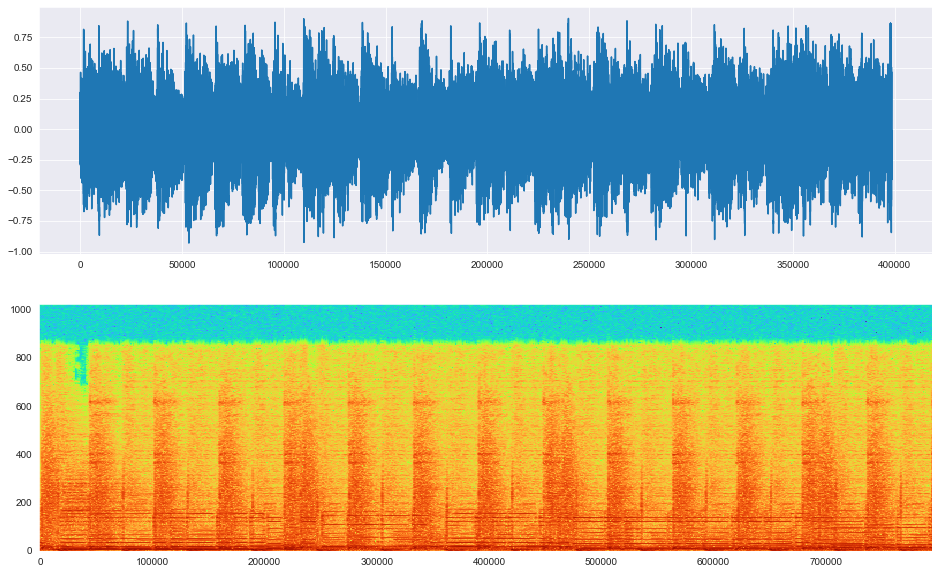

In [4]:
n = random.randint(0,len(audio_paths)-1)
path = audio_paths[n]
tab = tabs[n]
capo = capo_placements[n]

wav = extract_wav(path)
spec = make_spectrogram(wav,frame_length,frame_step)
print(path)
print(spec.shape)
plot_wave_and_spectrogram(path,frame_length,frame_step)

print()

n = random.randint(0,len(audio_paths)-1)
path = audio_paths[n]
tab = tabs[n]
capo = capo_placements[n]

wav = extract_wav(path)
spec = make_spectrogram(wav,frame_length,frame_step)
print(path)
print(spec.shape)
plot_wave_and_spectrogram(path,frame_length,frame_step)

In [5]:
height = 1024
width = 1024

def process_file(file):
    
    s = extract_wav(file)
    s = make_spectrogram(s,frame_length,frame_step)
    s = tf.expand_dims(s,axis=-1)
    s = tf.image.convert_image_dtype(s,tf.float32)
    s = tf.image.resize(s,(height,width))
    s = tf.squeeze(s)
    
    return s

### This turns the tabs (as strings) into a dictionary of lists, with each guitar string having its own list:

In [6]:
strings = ['e','B','G','D','A','E']
def make_structured_tab(tab_string):
    
    tab_dict = {s:[] for s in strings}
    for char in tab:
        if char in strings:
            current_string = char
        if char.isnumeric():
            tab_dict[current_string].append(int(char))
        if char == '-' or char in ['b','h','p']:
            tab_dict[current_string].append(-1)
    
    structured_tab = np.array([[tab_dict[s][i] for s in strings] for i in range(len(tab_dict['e'])-1)])
    
    return structured_tab

### Here, the data is processed such that each audio clip is turned into a spectrigram, which is the reshaped into a 1024x1024 array. Also, the capo is incorporated into the tab.

In [7]:
used_audio_paths = []
used_capo_placements = []
used_tabs = []

for i in range(len(audio_paths)):
    tab = tabs[i]
    try:
        structured_tab = make_structured_tab(tab)
        if structured_tab.shape[-1] == 6:
            used_audio_paths.append(audio_paths[i])
            used_capo_placements.append(capo_placements[i])
            used_tabs.append(structured_tab)
    except:
        continue
        
tab_length = 100
def process_tab(tab,capo,tab_length=tab_length):

    capo_mask = (tab>=0)*capo

    processed_tab = tab + capo_mask
    if len(tab) < tab_length+1:
        processed_tab = np.concatenate([np.ones((1,6))*-1,processed_tab,np.ones((tab_length-len(tab),6))*-1])
    else:
        processed_tab = np.concatenate([np.ones((1,6)),processed_tab[:tab_length]])
        
    processed_tab += 1
    
    return processed_tab

all_specs = np.array([process_file(path) for path in used_audio_paths])
processed_tabs = np.array([process_tab(used_tabs[i],used_capo_placements[i]) for i in range(len(used_tabs))])

max_fret = 20

processed_tabs /= 20

In [8]:
batch_size = 16

def make_dataset(specs,tabs):

    dataset = tf.data.Dataset.from_tensor_slices((specs,tabs))
    dataset = dataset.map(lambda s,t: ((s,t[:-1]),t[1:]))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

train_specs,test_specs,train_tabs,test_tabs = train_test_split(all_specs,
                                                              processed_tabs,
                                                              test_size=.1)

train_dataset = make_dataset(train_specs,train_tabs)
test_dataset = make_dataset(test_specs,test_tabs)
train_dataset.element_spec

((TensorSpec(shape=(None, 1024, 1024), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 100, 6), dtype=tf.float64, name=None)),
 TensorSpec(shape=(None, 100, 6), dtype=tf.float64, name=None))

### The next few cells contain the attention layer, as well as the encoder, which encodes the specrogram in a fixed-length array, and the decoder, which takes the output of the encoder as well as any previous predicted tabs and outputs a new prediction.

In [9]:
dropout_rate = .1
class AttentionLayer(keras.layers.Layer):
    
    def __init__(self,num_heads,key_dim,return_attention_scores=False,use_causal_mask=False,dropout_rate=dropout_rate):
        super().__init__()
        self.attention_layer = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=key_dim,
            dropout=dropout_rate
        )
        self.use_causal_mask = use_causal_mask
        self.layer_normalization = LayerNormalization()
        self.add = Add()
        
    def call(self,X,context=None):
        
        if context is None:
            context = X
            
        attention_output = self.attention_layer(
            query=X,
            key=context,
            value=context,
            use_causal_mask=self.use_causal_mask
        )
            
        X = self.add([X,attention_output])
        X = self.layer_normalization(X)
        
        return X
        
        
class FeedForward(keras.layers.Layer):
    
    def __init__(self,depth,dense_size,dropout_rate=.1):
        super().__init__()
        self.dense0 = Dense(dense_size,activation='relu')
        self.dense1 = Dense(depth)
        self.dropout = Dropout(dropout_rate)
        self.add = Add()
        self.layer_normalization = LayerNormalization()
        
    def call(self,X):
        
        X0 = self.dense0(X)
        X0 = self.dense1(X0)
        X0 = self.dropout(X0)
        X = self.add([X,X0])
        X = self.layer_normalization(X)
        
        return X

In [10]:
class Encoder(keras.layers.Layer):
    
    def __init__(self,layer_size,num_lstm_layers,num_attn_layers,num_heads,width=width):
        super().__init__()

        self.lstm_layers = [LSTM(layer_size,return_sequences=True) for _ in range(num_lstm_layers)]
        
        self.attention_layers = [AttentionLayer(num_heads=num_heads,key_dim=layer_size) for _ in range(num_attn_layers)]
        
        self.feed_forward = FeedForward(
            depth=layer_size,
            dense_size=width
        )
        
        self.num_lstm_layers = num_lstm_layers
        self.num_atten_layers = num_attn_layers
        
    def call(self,X):
        
        for i in range(self.num_lstm_layers):
            X = self.lstm_layers[i](X)
            
        for i in range(self.num_atten_layers):
            X = self.attention_layers[i](X)
                    
        X = self.feed_forward(X)
        
        return X

In [11]:
class Decoder(keras.layers.Layer):
    
    def __init__(self,layer_size,num_heads,num_attn_layers=1,width=width):
        super().__init__()
        
        self.previous_tab_lstm = LSTM(layer_size,return_sequences=True)
        self.causal_attention = AttentionLayer(num_heads=num_heads,
                                              key_dim=layer_size,
                                              use_causal_mask=True)
        self.cross_attention = AttentionLayer(num_heads=num_heads,
                                             key_dim=layer_size)
        self.attention_layers = [AttentionLayer(num_heads=num_heads,key_dim=layer_size) for _ in range(num_attn_layers)]
        
        self.feed_forward = FeedForward(
            depth=layer_size,
            dense_size=width
        )
        
        self.output_layer = Conv1D(6,1,activation='sigmoid')
        self.num_attn_layers = num_attn_layers
        
    def call(self,previous_tab,encoding):
        
        X = self.previous_tab_lstm(previous_tab)
        X = self.causal_attention(X)
        X = self.cross_attention(X,encoding)
        for i in range(self.num_attn_layers):
            X = self.attention_layers[i](X)
        X = self.feed_forward(X)
        X = self.output_layer(X)
        
        return X

### The model itself:

In [12]:
class GuitarTabModel(keras.Model):
    
    def __init__(self,layer_size,num_heads,num_lstm_layers,num_enc_attn_layers,num_dec_attn_layers=1,width=width):
        super().__init__()
        self.encoder = Encoder(layer_size,num_lstm_layers,num_enc_attn_layers,num_heads,width)
        self.decoder = Decoder(layer_size,num_heads,num_dec_attn_layers)
        
    def call(self,inputs):
        
        encoding,previous_tab = inputs
        
        X = self.encoder(encoding)
        X = self.decoder(previous_tab,X)
        
        return X

### The loss function accounts for the fact that the vast majority of the notes are 0 (i.e. not played) by increasing the loss wherever an actual note is played.

In [13]:
class WeightedLoss(keras.losses.Loss):

    def __init__(self,scale_factor):
        super().__init__()
        self.loss_fn = keras.losses.BinaryCrossentropy()
        self.scale_factor = scale_factor

    def call(self,y_true,y_pred):

        loss = self.loss_fn(y_true,y_pred)
        mask = tf.cast(y_true>0,tf.float32)
        positive_loss = (loss * mask) * self.scale_factor
        loss += positive_loss

        return tf.reduce_mean(loss)

scale_factor = 24
weighted_loss = WeightedLoss(scale_factor)

In [14]:
layer_size = 1024
num_heads = 4
num_lstm_layers = 1
num_enc_attn_layers = 3

model = GuitarTabModel(layer_size,num_heads,num_lstm_layers,num_enc_attn_layers)

batch = next(iter(train_dataset))
model(batch[0])
model.summary()

Model: "guitar_tab_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  60871680  
                                                                 
 decoder (Decoder)           multiple                  56708102  
                                                                 
Total params: 117,579,782
Trainable params: 117,579,782
Non-trainable params: 0
_________________________________________________________________


In [15]:
def convert_to_tab_string(raw_tab,remove_one=True):

    strings = ['e','B','G','D','A','E']
    tab_string = ''
    make_dashes = lambda char: '-' if char == '-1' or char == '-2' else char

    try:
        raw_tab = raw_tab.numpy().squeeze()
    except:
        raw_tab = raw_tab.squeeze()
    raw_tab = (raw_tab*max_fret).astype('int')
    if remove_one:
        raw_tab -= 1
    for i in range(len(strings)):
        guitar_string = raw_tab[:,i].astype('str').tolist()
        guitar_string = list(map(make_dashes,guitar_string))
        guitar_string = ''.join(guitar_string)
        c = 0
        for j in range(len(guitar_string)):
            if j%33 == 0:
                guitar_string = guitar_string[:j+c] + '|' + guitar_string[j+c:]
        tab_string += strings[i] + guitar_string + '\n'

    return tab_string

In [16]:
encoder = model.encoder
decoder = model.decoder

def predict_tab(spec,tab_length=tab_length):

    encoding = encoder(tf.expand_dims(spec,0))
    predicted_tab = np.zeros((tab_length,len(strings)))

    for i in range(tab_length):
        pred = tf.squeeze(decoder(tf.expand_dims(predicted_tab,0),encoding))[i]
        predicted_tab[i] += pred

    return predicted_tab

### Here's an example of what the output looks like (though the model is untrained):

In [17]:
n = random.randint(0,len(used_audio_paths))

path = used_audio_paths[n]
sound = extract_sound(path)
spec = all_specs[n]
original_tab = convert_to_tab_string(used_tabs[n],remove_one=False)
processed_tab = processed_tabs[n]
predicted_tab = predict_tab(spec)
predicted_tab = convert_to_tab_string(predicted_tab)
processed_tab = convert_to_tab_string(processed_tab[1:])

print(path.split('/')[-1].replace('.wav',''))

print('\nProcessed tab:\n',processed_tab)
print('\nPredicted tab:\n',predicted_tab)
sound

C:\Users\tblon\OneDrive\Desktop\Datasets\music-and-tabs\audio\the_rolling_stones_paint_it_black_intro_tab

Processed tab:
 e|----0---2---3---5---3---2---0---|0-------------------------------|--------------------------------|----
B|--------------------------------|----4---5---7---54--------------|--------------------------------|----
G|--------------------------------|--------------------------------|--------------------------------|----
D|--------------------------------|--------------------------------|--------------------------------|----
A|--------------------------------|--------------------------------|--------------------------------|----
E|--------------------------------|--------------------------------|--------------------------------|----


Predicted tab:
 e|11411111111111111111111121212121|21212121212121212121212121212121|21212121212121212121212121212121|21212121212121212121212121212121|21212121212121212121212121212121|21212121212121212121212121212121|2121212
B|2321111111111